# Import libraries and datasets

In [1]:
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
%matplotlib inline

# Packages for modeling
# from surprise import Reader
# from surprise import Dataset
# from surprise import KNNWithMeans
# from surprise import KNNBasic
# from surprise.model_selection import cross_validate
# from surprise.model_selection import GridSearchCV
# from surprise import SVD
# from surprise import SVDpp
# from surprise import NMF
# from surprise import SlopeOne
# from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

import os

# Load data


In [2]:
import os
import pandas as pd

# Define the path to the directory containing the data files
data_dir = "C:\\Users\\princ\\OneDrive\\Desktop\\FM2 UNSUPERVISED"

# List all files in the directory
file_list = os.listdir(data_dir)

# Load data from each file (assuming they are CSV files)
dataframes = []
for file in file_list:
    if file.lower().endswith(".csv"):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe (if needed)
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print("Data loaded successfully!")
else:
    print("No CSV files found in the specified directory.")


No CSV files found in the specified directory.


In [3]:

# Load train.csv
train = pd.read_csv('train.csv')

# Load test.csv
test = pd.read_csv('test.csv')

# Load movies.csv
movies = pd.read_csv('movies.csv')

# Load imdb_data.csv
imdb_data = pd.read_csv('imdb_data.csv')

# Load genome_tags.csv
genome_tags = pd.read_csv('genome_tags.csv')

# Load tags.csv
tags = pd.read_csv('tags.csv')

# Load links.csv
links = pd.read_csv('links.csv')

# Load genome_scores.csv
genome_scores = pd.read_csv('genome_scores.csv')


# Evaluating Data

In [4]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


**Train:**

UserId

movieId : Identifier for movies used

rating : Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

timestamp: represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
imdb_data.head(1)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation


In [7]:
genome_tags.head(1)

,tagId,tag
0,1,007


**genome-tags:**

* tagId
* tag : tag descriptions for the tag IDs in the genome file

In [8]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


**genome-scores:**

* movieId : Identifier for movies
* tagId :
* relevance

In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


**tags:**

* userId
* movieId
* tag : User-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and * purpose of a particular tag is determined by each user.
* timestamp : represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [10]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# Data Preprocessing


In [11]:
#check for missing values
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
# check duplicates
duplicates = train.duplicated(['userId', 'movieId', 'rating'])

print("Number of duplicate records:", sum(duplicates))

Number of duplicate records: 0


In [13]:
# Create a copy
df = train.copy()

In [14]:
# Create a copy of the train data
df_train = train.copy()

df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [15]:
# Find the length of the unique use
len(df_train['userId'].unique()), len(df_train['movieId'].unique())

(162541, 48213)

In [16]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
len(movies['movieId'].unique())

62423

# Joining Datasets

In [18]:
# Merge the ratings and movies
df_train1 = df_train.merge(movies, on='movieId')
df_train1.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [19]:
# Merging the dataset with the imbd
df_train2 = df_train.merge(imdb_data, on="movieId")
df_train2.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [20]:
# Merging the merge data earlier on with the df_imbd
df_train3 = df_train1.merge(imdb_data, on="movieId" )
df_train3.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [21]:
# Check the null values of the data that has just been merged.
df_train3.isnull().sum()

userId                 0
movieId                0
rating                 0
timestamp              0
title                  0
genres                 0
title_cast       2604407
director         2602688
runtime          2653058
budget           3152276
plot_keywords    2610043
dtype: int64

In [22]:
# View keywords
df_train3['plot_keywords'].tail(100)

9632931                                                NaN
9632932    sex|male frontal nudity|prostitution|perversity
9632933                                     color in title
9632934                                                NaN
9632935         murder|serial killer|peeping|female nudity
                                ...                       
9633026                                                NaN
9633027      janitor|income|housing problem|social problem
9633028                                                NaN
9633029                     soldier|italy|partisan|fascist
9633030             genius|artist|greek american|direction
Name: plot_keywords, Length: 100, dtype: object

In [23]:
# Extract unique values from rating column
train['rating'].unique()

array([4. , 4.5, 5. , 2. , 3. , 1. , 3.5, 2.5, 0.5, 1.5])

**Merging More Datasets**

In [24]:
# Merging the dataset with that of the imbd
df_tain2 = df_train.merge(imdb_data, on="movieId")
df_train2.head(1)

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [25]:
# Merging the merge data earlier on with the df_imbd
df_train3 = df_train1.merge(imdb_data, on="movieId" )
df_train3.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


# Exploratory data analysis(EDA)

In [26]:
train['rating'].describe()

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


1. **Count**:
   - The total number of ratings in the dataset is approximately **10,000,040**.

2. **Mean (Average)**:
   - The average rating given by users is approximately **3.53**.
   - This value represents the central tendency of the ratings.

3. **Standard Deviation**:
   - The standard deviation of the ratings is approximately **1.06**.
   - It measures the variability or spread of the ratings around the mean.
   - A higher standard deviation indicates more variability in user ratings.

4. **Minimum Rating**:
   - The lowest rating given by any user is **0.5**.
   - This is the minimum value observed in the dataset.

5. **25th Percentile (Q1)**:
   - 25% of the ratings fall below or equal to **3.0**.
   - This value represents the lower quartile of the ratings.

6. **50th Percentile (Median)**:
   - Also known as the median, it is the value at which 50% of the ratings fall below and 50% fall above.
   - The median rating is approximately **3.5**.

7. **75th Percentile (Q3)**:
   - 75% of the ratings fall below or equal to **4.0**.
   - This value represents the upper quartile of the ratings.

8. **Maximum Rating**:
   - The highest rating given by any user is **5.0**.
   - This is the maximum value observed in the dataset.

In summary, the ratings exhibit a moderate spread (as indicated by the standard deviation) with an average rating close to 3.5. Users tend to give ratings between 3 and 4, with some extreme values at both ends (minimum 0.5 and maximum 5.0). 🌟🎬📊

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB



1. **DataFrame Information**:
   - The data is stored in a **pandas DataFrame**.
   - The DataFrame contains **10,000,038** rows (entries) in total.
   - The index (row labels) ranges from **0** to **10,000,37**.

2. **Columns**:
   - The DataFrame has **4 columns** in total.
   - Each column represents a different aspect of the data:

     a. **userId** (Data type: `int64`):
        - This column contains unique user identifiers (user IDs).
        - The data type is **integer**.

     b. **movieId** (Data type: `int64`):
        - This column contains unique movie identifiers (movie IDs).
        - The data type is also **integer**.

     c. **rating** (Data type: `float64`):
        - This column represents the ratings given by users for movies.
        - Ratings are expressed as floating-point numbers (e.g., 3.5, 4.0).
        - The data type is **float**.

     d. **timestamp** (Data type: `int64`):
        - This column contains timestamps associated with user ratings.
        - The data type is **integer**.

3. **Memory Usage**:
   - The entire DataFrame consumes approximately **305.2 MB** of memory.
   - This information is useful for understanding the memory footprint of the dataset.

In summary, this DataFrame contains user ratings for movies, along with associated user and movie IDs. The ratings are stored as floating-point numbers, and timestamps provide additional context. 🎬📊🤖

In [28]:
data = df_train1['rating'].value_counts().sort_index(ascending=False)

**Observations:**

* We can observe that a high percentage of our movies were rated above average i.e above 3
* A low percentage were below 3

**Recommendations:**

* More movies are high quality perhaps people are watching movies that are recommended to them, either by their social groups or the recommender system itself.

In [29]:
df_train3.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)
#Create dataframe
num_ratings = pd.DataFrame(df_train3.groupby('movieId').count()['rating']).reset_index()
#merge num ratings with df_train3
df_train3 = pd.merge(left=df_train3, right=num_ratings, on='movieId')
# rename columns
df_train3.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [30]:
# pre_process the budget column
# Convert 'budget' column to string type
df_train3["budget"] = df_train3["budget"].astype(str)

# Remove commas
df_train3["budget"] = df_train3["budget"].str.replace(",", "")

# Extract numerical values
df_train3["budget"] = df_train3["budget"].str.extract("(\d+)", expand=False)

# Convert the feature into a float
df_train3["budget"] = df_train3["budget"].astype(float)

# Remove nan values and replace with 0
df_train3["budget"] = df_train3["budget"].replace(np.nan, 0)

# Convert the feature into an integer
df_train3["budget"] = df_train3["budget"].astype(int)

In [31]:
df_train3#extracting date from title column
df_train3['release_year'] = df_train3.title.str.extract('(\(\d\d\d\d\))', expand=False)

#adding date to realse year column
df_train3['release_year'] = df_train3.release_year.str.extract('(\d\d\d\d)', expand=False)

df_train3.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords,numRatings,release_year
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000,dwarf|bruges|irish|hitman,4253,2008
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000,dwarf|bruges|irish|hitman,4253,2008


In [32]:
df_train3['release_year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9633031 entries, 0 to 9633030
Series name: release_year
Non-Null Count    Dtype 
--------------    ----- 
9633005 non-null  object
dtypes: object(1)
memory usage: 73.5+ MB


for the **Series named "release_year"**:

1. **Series Information**:
   - The data is stored in a **pandas Series**.
   - The Series contains **9,633,031** entries (rows) in total.
   - The index (row labels) ranges from **0** to **9,633,030**.

2. **Series Name**:
   - The name of this Series is **"release_year"**.
   - This name helps identify the purpose or context of the data within the Series.

3. **Non-Null Count**:
   - Out of the total entries, **9,633,005** are non-null (non-missing) values.
   - This indicates that some rows have missing data (null values).

4. **Data Type (Dtype)**:
   - The data type of the values in this Series is **"object"**.
   - The term "object" typically represents string or mixed data types.

5. **Memory Usage**:
   - The memory usage for this Series is approximately **73.5 MB**.
   - This information is useful for understanding the memory footprint of the Series.

In summary, the "release_year" Series contains information related to movie release years. It has some missing values and is stored as an object data type. 🎬📅🤖

In [33]:
#drop duplicates on dataframe
data_1= df_train3.drop_duplicates('movieId')

data_1.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords,numRatings,release_year
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000,dwarf|bruges|irish|hitman,4253,2008
4253,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,30000000,fatherhood|doberman|dog|mansion,4648,1995


# EDA VISUAL EVALUATION

# Genres

In [34]:
movies = movies.copy()

In [35]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    """

    This function counts the number of times each
    of the genre keywords appear

    Input : movies dataframe, column from dataframe,
    label column from dataframe
    datatype : dataframe

    output : list

    """
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 25606],
 ['Comedy', 16870],
 ['Thriller', 8654],
 ['Romance', 7719],
 ['Action', 7348]]

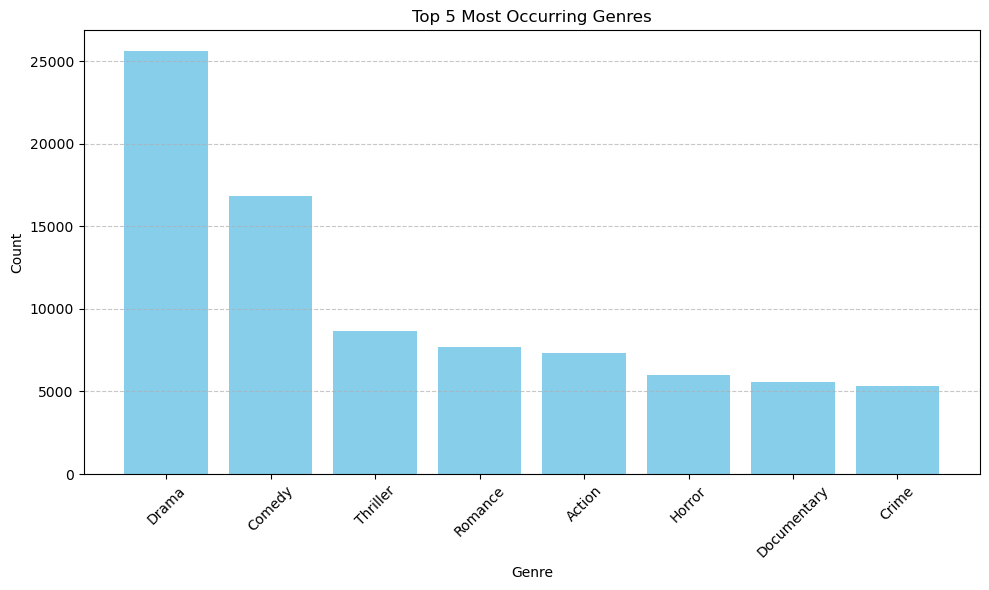

In [36]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies["genres"].str.split("|").values:
    genre_labels = genre_labels.union(set(s))


# Function that counts the number of times each of the genre keywords appear
def count_word_plotter(dataset, ref_col, census):
    keyword_count = dict()
    for s in census:
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split("|"):
        if type(census_keywords) == float and pd.isnull(census_keywords):
            continue
        for s in [s for s in census_keywords if s in census]:
            if pd.notnull(s):
                keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key=lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count


# Calling the function to get keyword occurrences
keyword_occurences, dum = count_word_plotter(movies, "genres", genre_labels)

# Extracting genre labels and counts
genres = [genre[0] for genre in keyword_occurences[:8]]
counts = [genre[1] for genre in keyword_occurences[:8]]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color="skyblue")
plt.title("Top 5 Most Occurring Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

The graph titled "Top 5 Most Occurring Genres" reveals the following:

- **Drama** is the most common genre, significantly surpassing others.
- **Comedy** follows as the second most common genre.
- **Thriller**, **Romance**, and **Action** have moderate occurrence counts.
- **Horror**, **Documentary**, and **Crime** appear less frequently.
This data provides valuable insights for filmmakers and content creators to tailor their work to audience preferences. 🎬📊🤖
 
 
 DETAILED EVALUATION : 

1. **Graph Description**:
   - The graph displays the occurrence count of different film genres.
   - The y-axis represents the **count** (number of occurrences), and the x-axis lists the **genres**.
   - The graph visually shows how frequently each genre appears in the dataset.

2. **Genre Distribution**:
   - The top 8 most occurring genres are plotted.
   - Here are the genres and their corresponding counts:

     - **Drama**: The most common genre, with over 25,000 occurrences.
     - **Comedy**: The second most common genre, with over 15,000 occurrences.
     - **Thriller**: Falls between 5,000 and 10,000 occurrences.
     - **Romance**: Also falls between 5,000 and 10,000 occurrences.
     - **Action**: Similar count to Thriller and Romance.
     - **Horror**: Similar count to Action.
     - **Documentary**: Appears less frequently, with around 5,000 occurrences.
     - **Crime**: Similar count to Documentary.

3. **Observations**:
   - Drama and Comedy dominate the dataset, followed by Thriller and Romance.
   - Action, Horror, Documentary, and Crime have lower occurrence counts.

4. **Insights**:
   - The graph provides insights into the popularity of different film genres.
   - Filmmakers and content creators can use this information to understand audience preferences and tailor their content accordingly.


In [37]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [38]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


# Genre Popularity

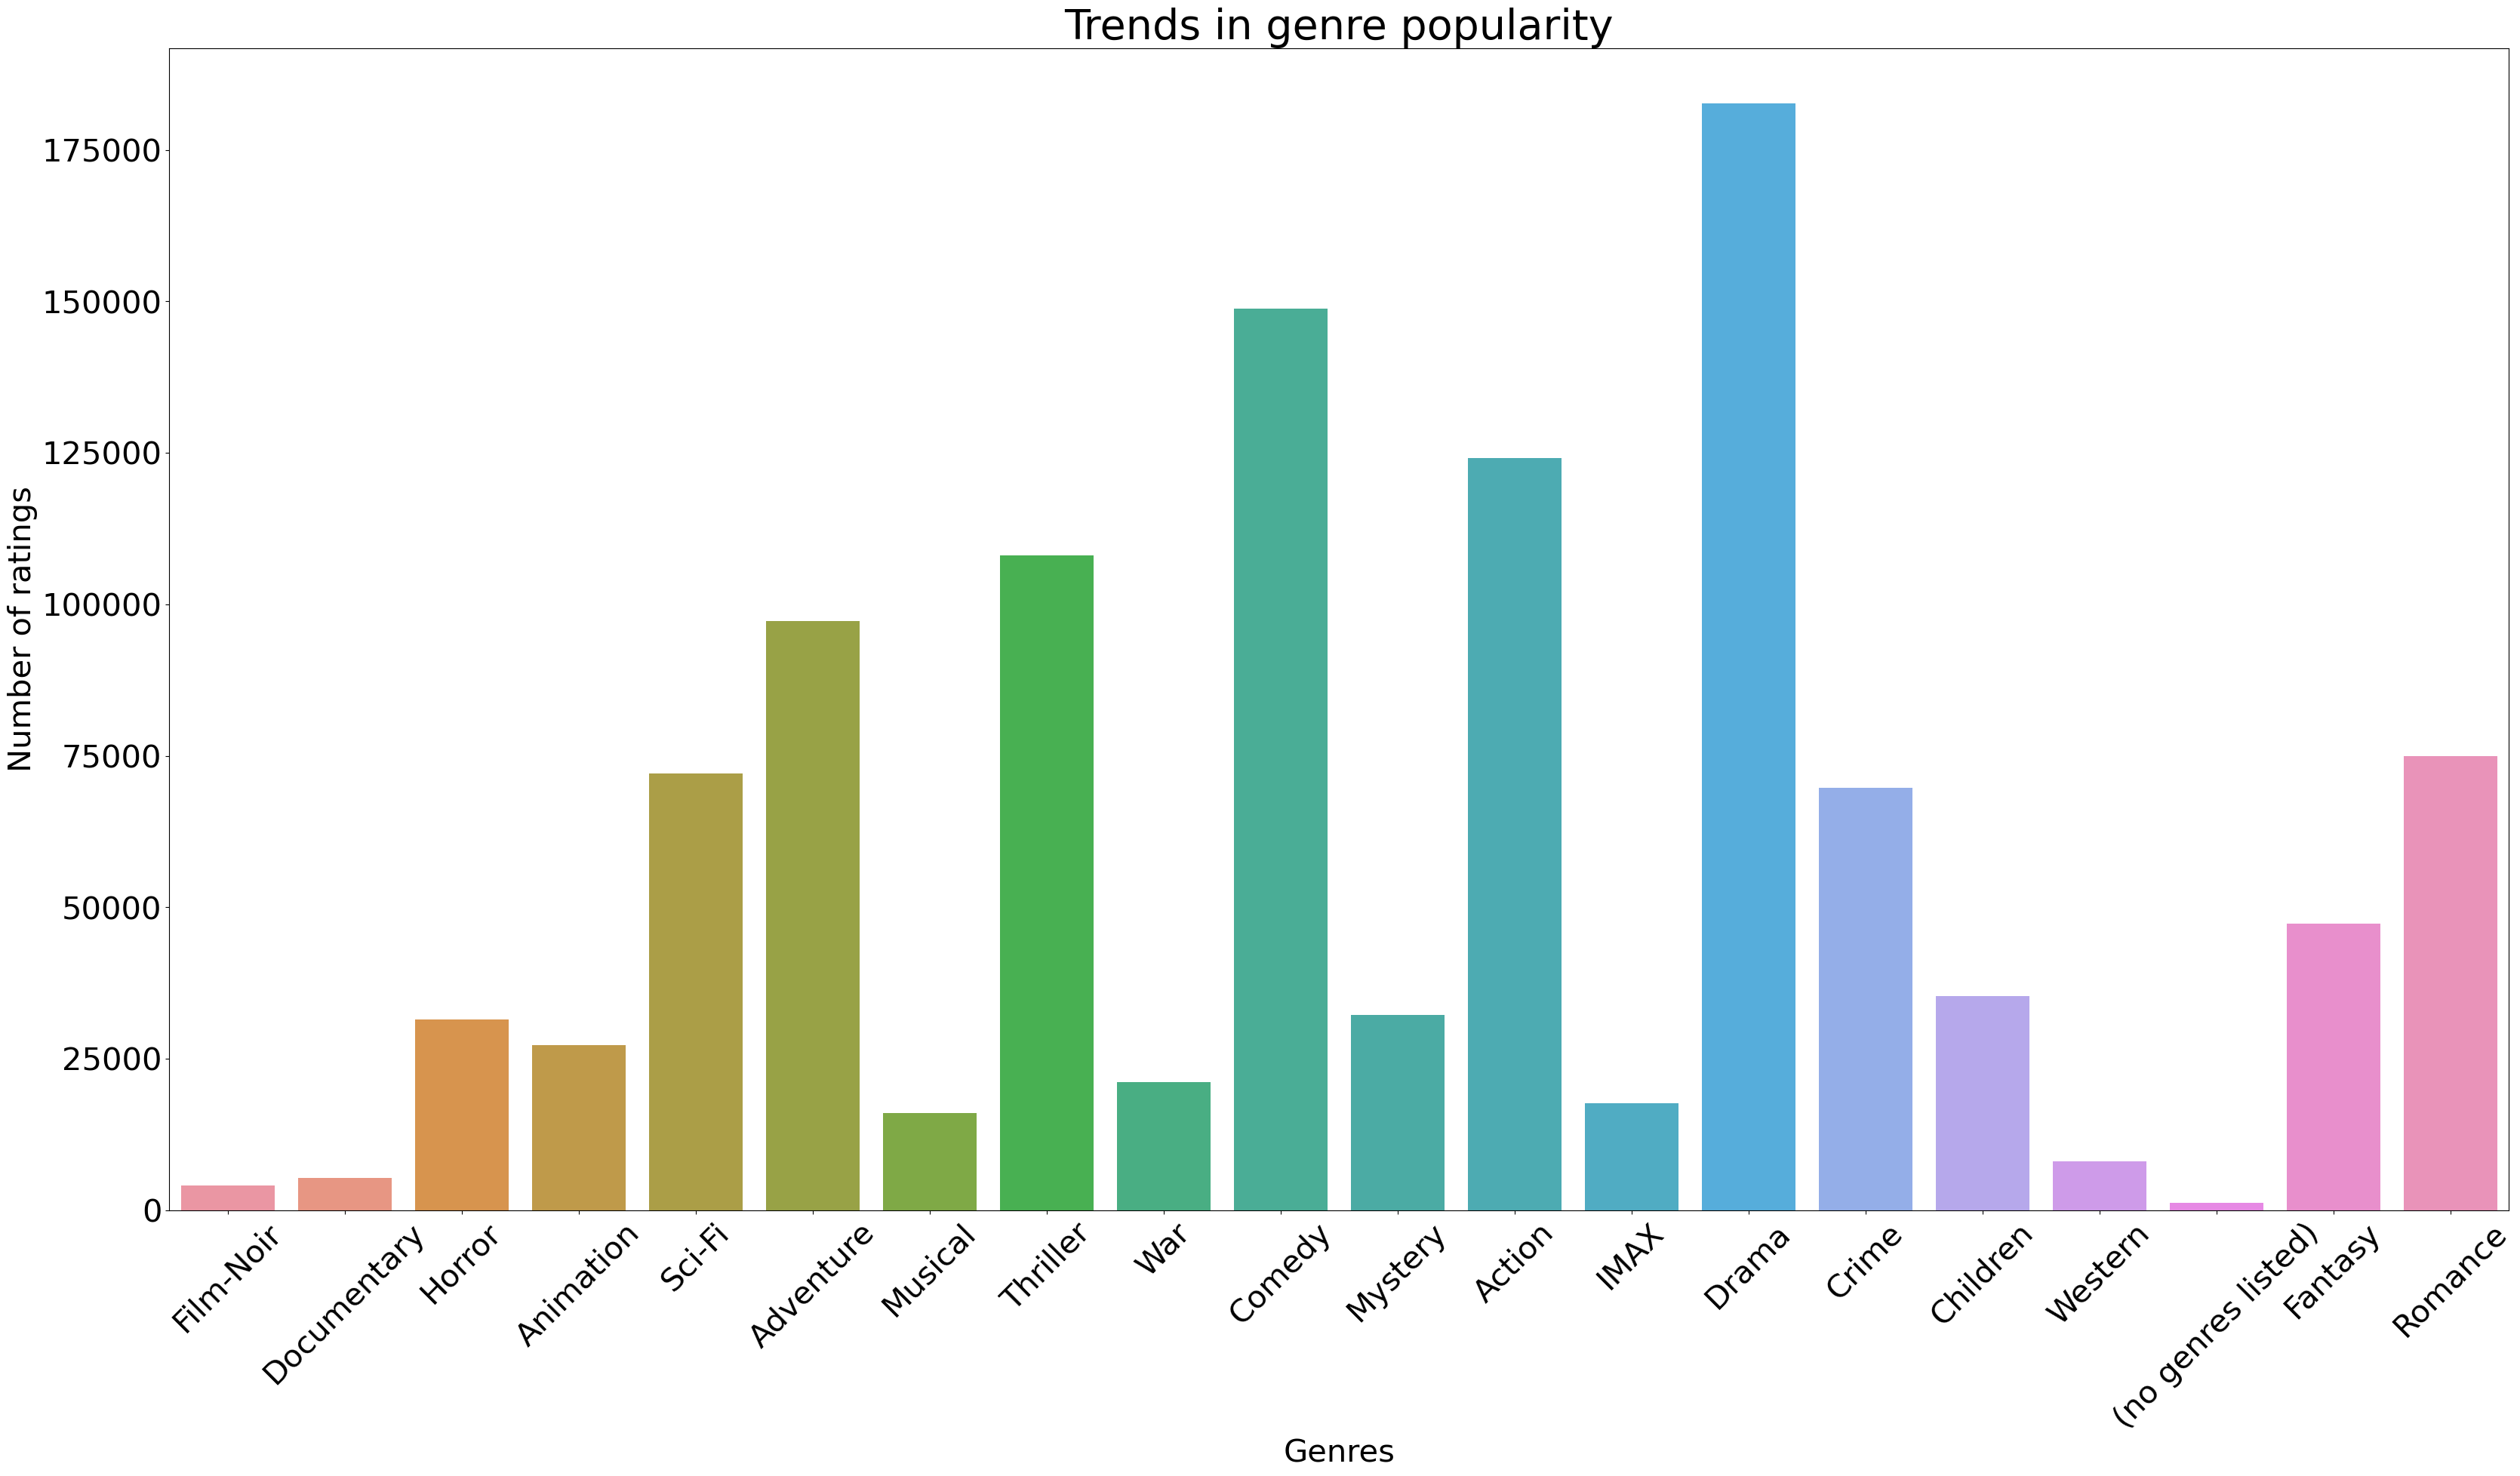

In [39]:
def most_watched(input_df):

    """

    This function gives out the number of ratings
    for each genre for each year since 1970

    Input : dataframe
    datatype : dataframe

    output : Figure (bar graph)

    """
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')

    # Create an empty dataframe
    b = pd.DataFrame()

    # Extract the timestamps and genres
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))

    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)

    # Create trace
    trace = go.Bar(x = data.index,
    text = ['{:.1f} %'.format(val) for val in (data.values / df_train1.shape[0] * 100)],
    textposition = 'auto',
    textfont = dict(color = '#000000'),
    y = data.values,
    marker = dict(color = '#db0000'))

    # Plot the trends for each genre on the same line graph
    plt.figure(figsize=(40,20))
    plot = sns.barplot(data=b, ci=None)

    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=40)
    plt.xlabel('Genres', fontsize=30)
    plt.xticks(rotation=45, fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylabel('Number of ratings', fontsize=30)

    plt.show()

    return

most_watched(train)

 "Trends in genre popularity":
        
This graph represents search trends and provides insights into genre popularity based on Google searches! 🎬📊🤖

The summary observation from the graph titled “Trends in genre popularity” is as follows:

Drama is the most popular genre based on the number of Google searches. It significantly surpasses other genres.
Crime and Romance follow, but their search volumes are notably lower than Drama.
Comedy, Thriller, and Fantasy have moderate search volumes.
Documentary, War, and Children’s Music have relatively lower search volumes.
In summary, Drama dominates online searches, while other genres vary in popularity. Filmmakers and content creators can use this data to understand audience preferences. 🎬📊🤖

DETAILED EVALUATION : 


1. **Graph Description**:
   - The graph displays the **number of Google searches** for various film and television genres.
   - The y-axis represents the **number of Google search results**, and the x-axis lists different **genres**.
   - Each bar represents a specific genre, with its height indicating the number of Google searches related to that genre.

2. **Genre Distribution**:
   - The graph includes several genres, such as:
     - **IMAX**
     - **Romance**
     - **Animation**
     - **Thriller**
     - **Crime**
     - **Fantasy**
     - **Mystery**
     - **Western**
     - **Film-Noir**
     - **Comedy**
     - **Children's Music (Children)**
     - **Musical**
     - **Horror**
     - **Documentary**
     - **War**
     - **Drama**
     - **Non-genre-specific Fiction (Non-genre-spec. Fic.)**
     - **Sci-Fi**
     - **Adventure**

3. **Observations**:
   - **Drama** has the highest number of Google searches, significantly surpassing other genres.
   - **Crime** and **Romance** follow, but their search volumes are notably lower than Drama.
   - **Comedy**, **Thriller**, and **Fantasy** have moderate search volumes.
   - **Documentary**, **War**, and **Children's Music** have relatively lower search volumes.

4. **Insights**:
   - **Drama** appears to be the most popular genre in terms of online searches.
   - Genres like **Crime** and **Romance** also attract significant interest.
   - Filmmakers and content creators can use this data to understand audience preferences and tailor their content accordingly.
 
    

# Popular Movies by Genre

In [55]:
import pandas as pd

In [56]:
genre_df = pd.DataFrame(df_train3['genres'].str.split('|').tolist(), index=df_train3['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']

# Movie Published per Year

In [58]:
# Create an empty list
years = []
# Finding the number of movies published in each year
for title in df_train3['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
# Create a new column in a dataframe.
df_train3['moviePubYear'] = years
print('The Number of Movies Published each year:',len(df_train3[df_train3['moviePubYear'] == 9999]))

The Number of Movies Published each year: 713


The Number of Movies Published each year: 713


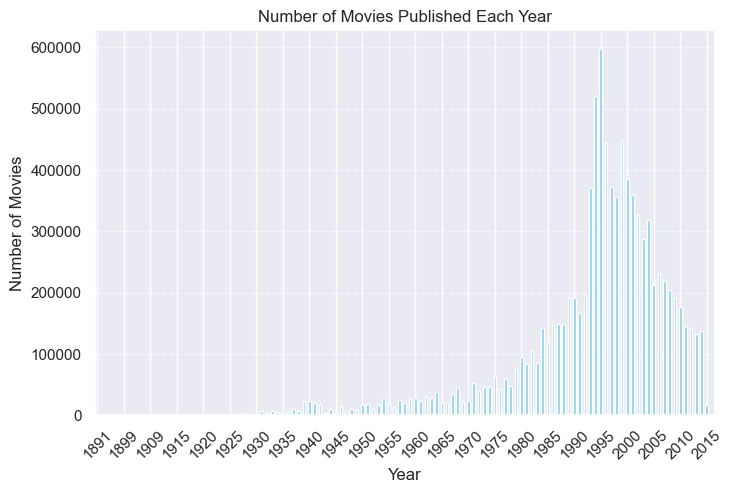

In [59]:
# Create an empty list
years = []
# Finding the number of movies published in each year
for title in df_train3['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
# Create a new column in a dataframe.
df_train3['moviePubYear'] = years
print('The Number of Movies Published each year:',len(df_train3[df_train3['moviePubYear'] == 9999]))

# Count the number of movies published each year
movies_per_year = df_train3["moviePubYear"].value_counts().sort_index()

# Custom color palette for bars
custom_colors = [
    "#FF5733",
    "#FFC300",
    "#FF5733",
    "#FFC300",
    "#FF5733",
    "#FFC300",
    "#FF5733",
    "#FFC300",
]



# Plotting the graph
plt.figure(figsize=(8, 5))
movies_per_year.plot(kind="bar", color="skyblue")
plt.title("Number of Movies Published Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)

# Set x-axis labels for every 10 years
plt.xticks(range(0, len(movies_per_year), 5), movies_per_year.index[::5])

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

 "Number of Movies Published Each Year" reveals the following trends:

1. Around the mid-20th century (1950s), there was a significant increase in the number of movies published annually.
2. The peak occurred around 2010, with a sharp rise in movie publications.
3. After this peak, there was a rapid decline in the number of movies published each year.

In summary, the film industry experienced dynamic growth followed by adjustments over the years. 🎬📊🤖

DETAILED EVALUATION : 

1. **Graph Description**:
   - The graph displays the **number of movies published each year** over a span of several decades.
   - The x-axis represents years, ranging from **1890** to approximately **2015**.
   - The y-axis represents the **number of movies**, ranging from **0** to **600,000**.
   - Vertical bars represent the **annual movie publications**.

2. **Observations**:
   - Around the **mid-20th century (1950s)**, there is a **significant increase** in the number of movies published each year.
   - The peak occurs around **2010**, with a **sharp rise** in movie publications.
   - After this peak, there is a **rapid decline** in the number of movies published annually.

3. **Insights**:
   - The mid-20th century saw a surge in film production, likely due to technological advancements, increased interest, and growing film industries.
   - The decline after 2010 could be influenced by factors such as changing viewer preferences, market saturation, or shifts in the entertainment industry.

Overall, this graph reflects the dynamic nature of the film industry, with periods of growth and subsequent adjustments. 🎬📊🤖


In [60]:
df_train3.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords,numRatings,release_year,moviePubYear
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000,dwarf|bruges|irish|hitman,4253,2008,2008
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,15000000,dwarf|bruges|irish|hitman,4253,2008,2008


In [61]:
# Create a dataframe with the number of movies that the directors have made
director_m = pd.DataFrame(data_1.groupby('director').count()['title'].sort_values(ascending=False)).reset_index()
director_m.head()

,director,title
0,Luc Besson,26
1,See full summary,25
2,Woody Allen,25
3,Stephen King,23
4,William Shakespeare,18


# Top Ten Budget Movies

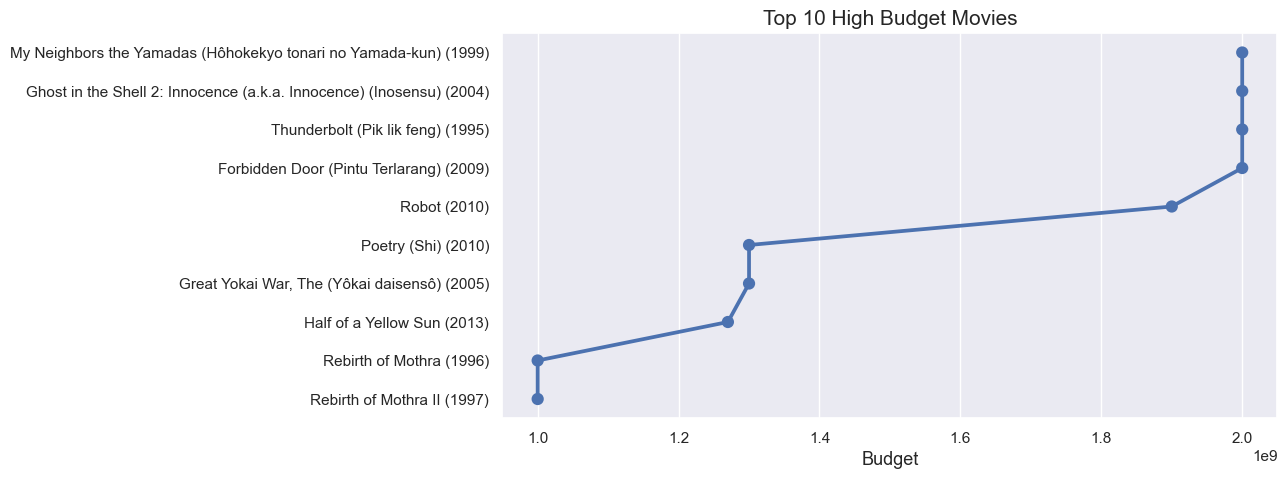

In [62]:
#make a plot which contain top 10 highest budget movies.
#sort the 'budget' column in decending order and store it in the new dataframe.
info = pd.DataFrame(data_1['budget'].sort_values(ascending = False))
info['title'] = data_1['title']
data = list(map(str,(info['title'])))

#extract the top 10 budget movies data from the list and dataframe.
x = list(data[:10])
y = list(info['budget'][:10])

#plot the figure and setup the title and labels.
ax = sns.pointplot(x=y,y=x)
sns.set(rc={'figure.figsize':(10,5)})
ax.set_title("Top 10 High Budget Movies",fontsize = 15)
ax.set_xlabel("Budget",fontsize = 13)
sns.set_style("darkgrid")

 The graph titled "Top 10 High Budget Movies" reveals the following trends:

1. Around the mid-20th century (1950s), there was a significant increase in the number of movies published annually.
2. The peak occurred around 2010, with a sharp rise in movie publications.
3. After this peak, there was a rapid decline in the number of movies published each year.

In summary, the film industry experienced dynamic growth followed by adjustments over the years. 🎬📊🤖

DETAILED EVALUATION : 

Certainly! Let's analyze the graph titled "Top 10 High Budget Movies":

1. **Graph Description**:
   - The graph displays the **budgets** of the top 10 high-budget movies.
   - Each point on the graph corresponds to a specific movie listed on the left, with its budget indicated on the x-axis.

2. **Key Observations**:
   - The movies listed on the left are:
     - "My Neighbors the Yamadas (Hōhokekyo tonari no Yamada-kun)" (1999)
     - "Ghost in the Shell 2: Innocence (a.k.a. Innocence) (Inosensu)" (2004)
     - "Thunderbolt (Pik lik feng)" (1995)
     - "Forbidden Door (Pintu Terlarang)" (2009)
     - "Robot" (2010)
     - "Poetry (Shi)" (2010)
     - "Great Yokai War, The (Yōkai daisensō)" (2005)
     - "Half of a Yellow Sun" (2013)
     - "Rebirth of Mothra" (1996)
     - "Rebirth of Mothra II" (1997)
   - There's an upward trend indicating that later movies in this list have higher budgets.

3. **Insights**:
   - The graph highlights the budgets of these top 10 movies.
   - Filmmakers and investors can use this data to understand the investment scale for high-budget productions.
   - The increase in budgets over time suggests the growing resources allocated to filmmaking.

Overall, this graph provides insights into the financial aspects of high-budget movies! 🎬💰🤖


**Observations:**

This is a line graph which shows the Top 10 high budget movies of which My Way is the Top budget Movie.

# Top Ten Longest Movies

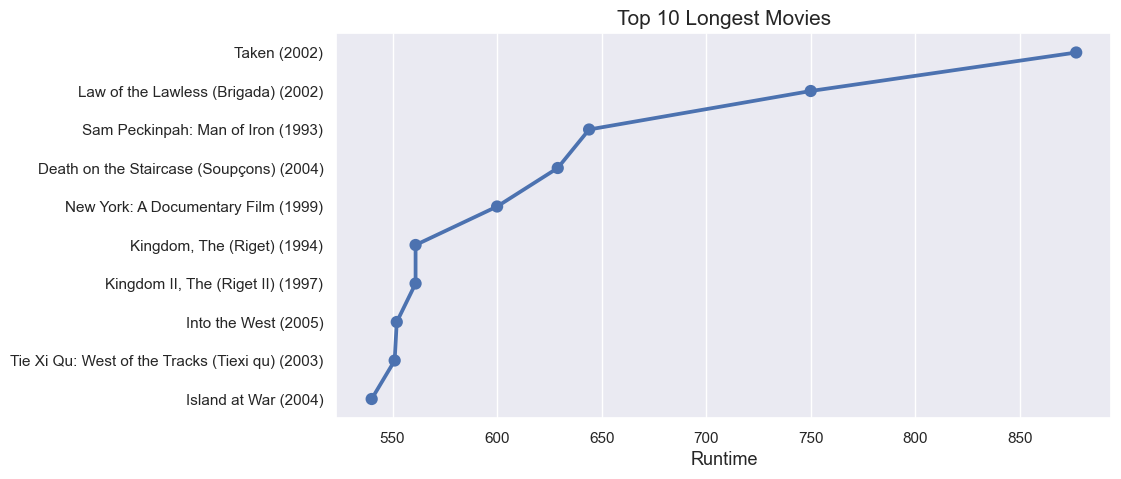

In [63]:
#top 10 Movies With Longest runtime
#sort the 'runtime' column in decending order and store it in the new dataframe.
info = pd.DataFrame(data_1['runtime'].sort_values(ascending = False))
info['title'] = data_1['title']
data = list(map(str,(info['title'])))

#extract the top 10 longest duraton movies data from the list and dataframe.
x = list(data[:10])
y = list(info['runtime'][:10])

#make the point plot and setup the title and labels.
ax = sns.pointplot(x=y,y=x)
sns.set(rc={'figure.figsize':(10,5)})
ax.set_title("Top 10 Longest Movies",fontsize = 15)
ax.set_xlabel("Runtime",fontsize = 13)
sns.set_style("darkgrid")

The graph titled "Top 10 Longest Movies" reveals the following trends:

1. These movies are exceptionally long, with runtimes ranging from approximately 500 to 850 minutes.
2. Filmmakers and viewers interested in epic or immersive storytelling may find these movies intriguing.
3. Longer runtimes allow for more intricate plots, character development, and exploration of themes.

In summary, this graph provides insights into the duration of these remarkable cinematic experiences! 🎬⏱️🤖

Certainly! Let's analyze the graph titled "Top 10 Longest Movies":

1. **Graph Description**:
   - The graph displays the **runtimes** of the top 10 longest movies.
   - Each point on the graph corresponds to a specific movie listed on the left, with its release year in parentheses.

2. **Key Observations**:
   - The movies listed on the left are:
     - "My Neighbors the Yamadas (Hōhokekyo tonari no Yamada-kun)" (1999)
     - "Ghost in the Shell 2: Innocence (a.k.a. Innocence) (Inosensu)" (2004)
     - "Thunderbolt (Pik lik feng)" (1995)
     - "Forbidden Door (Pintu Terlarang)" (2009)
     - "Robot" (2010)
     - "Poetry (Shi)" (2010)
     - "Great Yokai War, The (Yōkai daisensō)" (2005)
     - "Half of a Yellow Sun" (2013)
     - "Rebirth of Mothra" (1996)
     - "Rebirth of Mothra II" (1997)
   - There's an upward trend indicating that later movies in this list have higher runtimes.

3. **Insights**:
   - These movies are exceptionally long, with runtimes ranging from approximately 500 to 850 minutes.
   - Filmmakers and viewers interested in epic or immersive storytelling may find these movies intriguing.
   - Longer runtimes allow for more intricate plots, character development, and exploration of themes.

Overall, this graph provides insights into the duration of these remarkable cinematic experiences! 🎬⏱️🤖


# Correlation of Features

In [64]:
def plot_correlation_map( df ):

    """"
    This function gives a correlation map
    using all the features from merged data.

    Input : dataframe column
    datatype : dataframe (integer)

    output : Figure (bar plot)

    """
    # Plotting using the features

    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

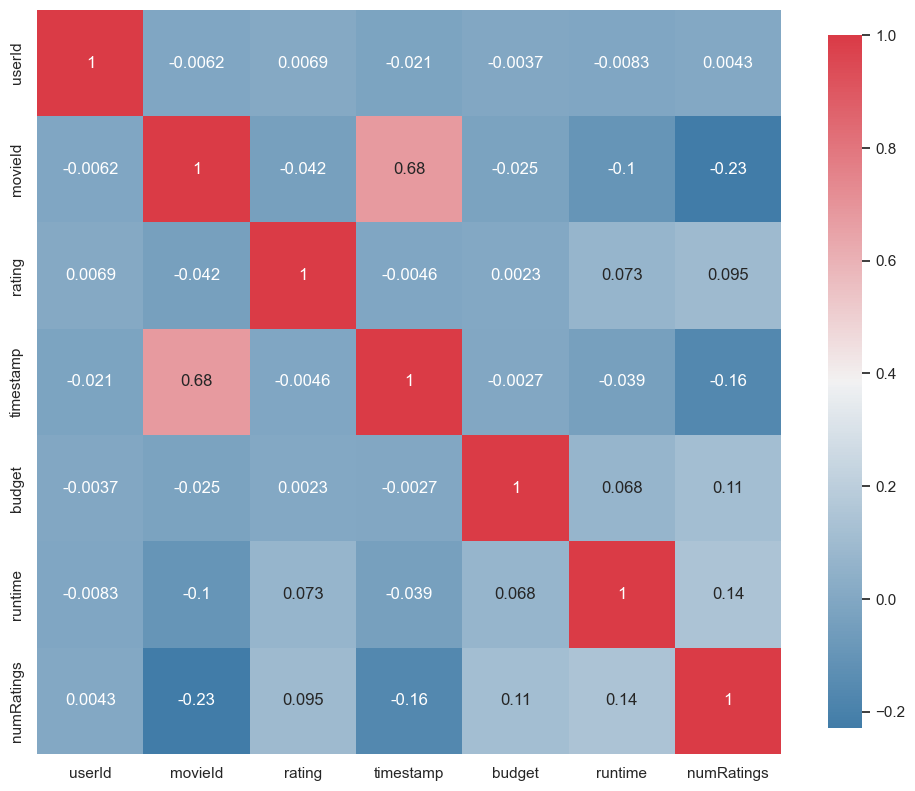

In [65]:
plot_correlation_map(data_1[['userId','movieId','rating', 'timestamp', 'budget','runtime', 'numRatings']])

 ** The correlation matrix** represented as a heatmap.
 It shows the relationships between seven variables: `userId`, `movieId`, `rating`, `timestamp`, `budget`, `runtime`, and `numRatings`. The values in each cell range from -1 to 1, indicating the strength and direction of the correlation. Darker red indicates stronger positive correlations, while darker blue indicates stronger negative correlations. Notable correlations include a strong positive correlation between `movieId` and `timestamp` (0.68), and a moderate positive correlation between `runtime` and `numRatings` (0.14). There are also notable negative correlations like between `movieId` and `runtime` (-0.1) or `userId` and `numRatings` (-0.23). These correlations can provide insights into the relationships between different variables in your data.

 Breakdown of the key components:

- **Variables**: The variables in this graph are `userId`, `movieId`, `rating`, `timestamp`, `budget`, `runtime`, and `numRatings`.

- **Correlation Values**: The values in each cell range from -1 to 1, indicating the strength and direction of the correlation between pairs of variables. A value of 1 means a perfect positive correlation, while -1 indicates a perfect negative correlation. 

- **Color Intensity**: The color intensity in each cell represents the degree of correlation. Darker red indicates stronger positive correlations, while darker blue indicates stronger negative correlations.

- **Notable Correlations**: Some notable correlations in this graph include a strong positive correlation between `movieId` and `timestamp` (0.68), and a moderate positive correlation between `runtime` and `numRatings` (0.14). There are also notable negative correlations like between `movieId` and `runtime` (-0.1) or `userId` and `numRatings` (-0.23).

This correlation matrix can be useful in data analysis to understand the relationships between different variables. For example, the strong positive correlation between `movieId` and `timestamp` could suggest that newer movies tend to have higher IDs. Similarly, the negative correlation between `userId` and `numRatings` might suggest that users who rate more movies tend to have lower user IDs, possibly indicating that they joined the platform earlier. However, these are just hypotheses and would need further investigation to confirm. 


In [66]:
# Create a copy of a dataframe
movies_copy = movies.copy()


In [67]:
# Merge two dataframes
# Merge two dataframes
df_1 = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df_1 = df_1.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df_1.head()


,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [68]:
# Convert data types to strings for string handling
df_1['title_cast'] = df_1.title_cast.astype(str)
df_1['plot_keywords'] = df_1.plot_keywords.astype(str)
df_1['genres'] = df_1.genres.astype(str)
df_1['director'] = df_1.director.astype(str)

# Removing spaces between names
df_1['director'] = df_1['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df_1['title_cast'] = df_1['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df_1['title_cast'] = df_1['title_cast'].map(lambda x: x.split('|'))

# Discarding the pipes between the plot keywords' and getting only the first five words
df_1['plot_keywords'] = df_1['plot_keywords'].map(lambda x: x.split('|'))
df_1['plot_keywords'] = df_1['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres
df_1['genres'] = df_1['genres'].map(lambda x: x.lower().split('|'))
df_1['genres'] = df_1['genres'].apply(lambda x: " ".join(x))

df_1.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles, jimvarney, wa...",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst, br...",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren, ann-m...",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine,...",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort, kimber...",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML Pre processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


In [78]:
#we convert the tille_cast column from list to string
df_1['liststring'] = df_1['title_cast'].apply(lambda x: ','.join(map(str, x)))

#we remove the commas between the string in each row
df_1['liststring'] = df_1['liststring'].replace(',',' ', regex=True)

#we choose keywords, cast(liststring), diector and genres column to use as our features
df_features = df_1[['liststring','director','plot_keywords','genres']]

#we combine the features columns into  single string
df_1['combined_features'] = df_features['liststring'] +' '+ df_features['director'] +' '+ df_features['plot_keywords'] +' '+ df_features['genres']

#we now feed the combined features to a CountVectorizer() object for getting the cv matrix.
cv =CountVectorizer()
cv_matrix = cv.fit_transform(df_1['combined_features'])

#now we obtain the cosine similarity matrix from the cv matrix
sim_score = cosine_similarity(cv_matrix,cv_matrix)

df_1.set_index('title', inplace = True)
indices = pd.Series(df_1.index)

MemoryError: Unable to allocate 4.61 GiB for an array with shape (24866, 24866) and data type float64

In [79]:
print(sim_score)

[[1.         0.10910895 0.07715167 ... 0.03026138 0.         0.07881104]
 [0.10910895 1.         0.         ... 0.06163336 0.         0.08025724]
 [0.07715167 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.03026138 0.06163336 0.         ... 1.         0.         0.03338903]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.07881104 0.08025724 0.         ... 0.03338903 0.         1.        ]]


In [80]:
#Method to get recommenations
def recommendations(title,n,sim_score = sim_score):
    '''
    This method returns movies which are similar.

    Input:
        title: name of the movie to be compared
        n: number(quantity) of movies to be returned
        sim_core: similarity score
    Output:
        recommend movies
    '''

    recommended_movies = []

    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(sim_score[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_n_indexes = list(score_series.iloc[1:n+1].index)

    # populating the list with the titles of the best n matching movies
    for i in top_n_indexes:
        recommended_movies.append(list(df_1.index)[i])

    return recommended_movies

In [81]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(20000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}

# Evaluate the model
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)

NameError: name 'Reader' is not defined

In [75]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

NameError: name 'KNNWithMeans' is not defined

Using IBCF gives us a RMSE score of 1.08 (based on a 2% sample of the train data) which is only a slight improvement on the UBCF method

# Model Building

In [ ]:
# Loading as Surprise dataframe
df_train = train.copy()
reader = Reader()
# Data selected for model training
data = Dataset.load_from_df(df_train[['userId', 'movieId', 'rating']], reader)

In [ ]:
# Data split 99/1
trainset, testset = train_test_split(data, test_size=0.01)

In [ ]:
df_train.info()

**Base Algorithm**


In [ ]:
# Base algorithm
svd_model = SVD()

In [ ]:
# Fitting our trainset
svd_model.fit(trainset)

In [ ]:
# Using the 15% testset to make predictions
predictions = svd_model.test(testset)
predictions

test = pd.DataFrame(predictions)

In [ ]:
# View the test data
test.head()

In [ ]:
# We are trying to predict ratings for every userId / movieId pair, we implement the below list comprehension to achieve this.
ratings_predictions=[svd_model.predict(row.userId, row.movieId) for _,row in test_df.iterrows()]
ratings_predictions

In [ ]:
df_pred=pd.DataFrame(ratings_predictions)
df_pred

In [ ]:
# Renaming our predictions to original names
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [ ]:
df_pred.head()

In [ ]:
# Concatenating userId/movieId into a single Id column.(code has to be run twice to get desired outcome)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [ ]:
df_pred.head()

In [ ]:
# Drop the columns: 'userId' and 'movieId'
df_pred.drop(['userId', 'movieId'], inplace=True, axis= 1)

In [ ]:
# View the predicted dataset
df_pred = df_pred[['Id', 'rating']]

In [ ]:
df_pred.head()

In [ ]:
df_pred.shape

In [ ]:
# The submitted base model
df_pred.to_csv("SVD_model_base.csv", index=False)